In [ ]:
!wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/vangogh2photo.zip	 vangogh2photo.zip
!unzip vangogh2photo.zip

In [ ]:
# Importing used libraries

import os
import tqdm 
import random
import itertools
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# To produce the same results for every run
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
random.seed(42)
np.random.seed(42)

# Directories for train images
photo_dir = '/content/vangogh2photo/trainB'
painting_dir = '/content/vangogh2photo/trainA'

# Training resolution 256x256
img_size = 256
# Configs for training
total_iteration = 10
iter_to_save = 10 #to save the trained model

tot_ep = 200
decay = 100

class ImageDataset(torch.utils.data.Dataset):
  def __init__(self, photo_dir, painting_dir, img_size):
      self.PH_dir = photo_dir
      self.PA_dir = painting_dir
      self.PH_imgs = []
      self.PA_imgs = []
      for filename in os.listdir(photo_dir):
          self.PH_imgs.append(filename)
      for filename in os.listdir(painting_dir):
          self.PA_imgs.append(filename)
        
      self.transform = transforms.Compose([transforms.Resize(int(img_size*1.12), Image.BICUBIC),
                           transforms.RandomCrop(img_size), #extract a patch of size img_size from the input images (data augmentation)
                           transforms.RandomHorizontalFlip(), #flip the images, again data augmentation
                           transforms.ToTensor(),  
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

  def __getitem__(self, index):
    temp = Image.open(os.path.join(self.PH_dir, self.PH_imgs[random.randint(0, len(self.PH_imgs) - 1)])).convert('RGB') 
    photo = self.transform(temp)
    temp = Image.open(os.path.join(self.PA_dir, self.PA_imgs[(index) % len(self.PA_imgs)])).convert('RGB')                                         
    paint = self.transform(temp)
    return photo, paint

  def __len__(self):
    return max(len(self.PH_imgs), len(self.PA_imgs))

class SampleBatch(torch.utils.data.sampler.BatchSampler):
  def __init__(self, batchSampler, iterations, start=0):
      self.batchSampler = batchSampler
      self.iterations = iterations
      self.start = start
  def __iter__(self):
        index = self.start
        while index <= self.iterations:
            for batch in self.batchSampler:
                index = index + 1
                if index > self.iterations:
                    break
                yield batch
  def __len__(self):
        return self.iterations


class Residual(nn.Module):

    def __init__(self, in_channel):
        super(Residual, self).__init__()

        self.convBlock = nn.Sequential( nn.Conv2d(in_channel, in_channel, 3, padding=1, padding_mode='reflect'),
                                        nn.InstanceNorm2d(in_channel),
                                        nn.ReLU(inplace=True),
                                        nn.Conv2d(in_channel, in_channel, 3, padding=1, padding_mode='reflect'),
                                        nn.InstanceNorm2d(in_channel),
                                        nn.ReLU(inplace=True), )

    def forward(self, ind):
        return ind + self.convBlock(ind)

class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        # Initial convolution block       
        model = [nn.Conv2d(3, 64, kernel_size=7, padding=3, padding_mode='reflect'),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Encoding aka downsampling
        model = model + [nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                        nn.InstanceNorm2d(128),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
                        nn.InstanceNorm2d(256),
                        nn.ReLU(inplace=True) ] 
                         
        # Residual blocks
        for _ in range(9): #9 residual blocks
            model = model + [Residual(256)]

        # Decoding
        model = model + [ nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
                          nn.InstanceNorm2d(128),
                          nn.ReLU(inplace=True),
                          nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
                          nn.InstanceNorm2d(64),
                          nn.ReLU(inplace=True) ]                          
        # Output layer
        model = model + [nn.Conv2d(64, 3, kernel_size = 7, padding=3, padding_mode='reflect'), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, index):
        return self.model(index)

    def load(self, model):
        self.load_state_dict(torch.load(model, map_location=lambda storage, loc: storage)) #Load the model onto the CPU

    def save(self, model_path):
        torch.save(self.state_dict(), model_path)

class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()

        model = [   nn.Conv2d(3, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True), 
                    nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True), 
                    nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True), 
                    nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]
        model = model + [nn.Conv2d(512, 1, 4, padding=1)]
        self.model = nn.Sequential(*model)

    def forward(self, x):
       x =  self.model(x)
       return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1) #average pooling and squeezing
   
    def load(self, model):
        self.load_state_dict(torch.load(model, map_location=lambda storage, loc: storage))

    def save(self, model_path):
        torch.save(self.state_dict(), model_path)



# Weight initializaiton to N(0, 0.2)
def assign_weights(r):
  if isinstance(r, nn.Conv2d):
    torch.nn.init.normal_(r.weight.data, 0.0, 0.02)
    
class ReplayBuffer(): #used to train the discriminator
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data): #adding or retrieving an image
        bulwark = []
        data = data.detach()
        for thing in data:
          if len(self.data) < self.max_size:
              self.data.append(thing)
              bulwark.append(thing)
          else:
              if random.uniform(0,1) > 0.5:
                  k = random.randint(0, self.max_size-1)
                  bulwark.append(self.data[k].clone())
                  self.data[k] = thing
              else:
                  bulwark.append(thing)
        return torch.stack(bulwark)

# LambdaLR Scheduler Definition: Adjusts learning rate
class LambdaLearningRate(): # Learning rate is flat till start_dec epochs, then it reduces to 0 linearly at end of the training.
    def __init__(self, total_ep, start_dec):
        self.total_ep = total_ep #200
        self.start_dec = start_dec #100

    def step(self, epoch):
        if epoch - self.start_dec <= 0:
          return 1.0
        else:
          return 1.0 - (epoch - self.start_dec)/(self.total_ep - self.start_dec)

# Training
# Forward is photo to painting, backward is painting to photo
genForward = Generator().cuda().train() #train mode
genBackward = Generator().cuda().train()
disPh = Discriminator().cuda()
disPa = Discriminator().cuda()


# Assigning weights
genForward.apply(assign_weights)
genBackward.apply(assign_weights)
disPh.apply(assign_weights)
disPa.apply(assign_weights)


# Adam Optimizer
# Optimizers & LR schedulers
optimizerGenerator = torch.optim.Adam(itertools.chain(genForward.parameters(), genBackward.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizerDiscriminator = torch.optim.Adam(itertools.chain(disPh.parameters(), disPa.parameters()), lr=0.0002, betas=(0.5, 0.999))
schedulerGen = torch.optim.lr_scheduler.LambdaLR(optimizerGenerator, lr_lambda=LambdaLearningRate(tot_ep, decay).step)
schedulerDisc = torch.optim.lr_scheduler.LambdaLR(optimizerDiscriminator, lr_lambda=LambdaLearningRate(tot_ep, decay).step)

dataset = ImageDataset(photo_dir, painting_dir, img_size)
batch_sampler = torch.utils.data.sampler.BatchSampler(sampler=torch.utils.data.RandomSampler(dataset), batch_size=1, drop_last=True)
batch_sampler = SampleBatch(batch_sampler, iterations=total_iteration)
train_loader = torch.utils.data.DataLoader(dataset, num_workers=2, batch_sampler=batch_sampler, pin_memory=True)


fake_Photo_buffer = ReplayBuffer() #Replay buffer keeps generated images
fake_Paint_buffer = ReplayBuffer()

def forward_translator(photo, paint):
  identity_paint = genForward(paint)
  faked_paint = genForward(photo) 
  return faked_paint, genBackward(faked_paint), identity_paint

def backward_translator(photo, paint):
  identity_photo = genBackward(photo)
  faked_photo = genBackward(paint) 
  return faked_photo, genForward(faked_photo), identity_photo

# Definition for Loss Functions for Network Optimizations

MSE = torch.nn.MSELoss()
cycleLoss = torch.nn.L1Loss()
identityLoss = torch.nn.L1Loss()

for epoch in range(0, tot_ep):
  print("\nepoch"+str(epoch))
  for iteration, (photo_imgs, painting_imgs) in tqdm.tqdm(enumerate(train_loader)):
      photo_imgs = photo_imgs.cuda() 
      painting_imgs = painting_imgs.cuda()
      label1 = torch.cuda.FloatTensor(photo_imgs.shape[0], 1).fill_(1.0)
      label0 = torch.cuda.FloatTensor(photo_imgs.shape[0], 1).fill_(0.0)
      optimizerGenerator.zero_grad()
      
      # Photo to Painting, then Painting to Photo
      faked_paint, restored_photo, identity_paint = forward_translator(photo_imgs,painting_imgs)
      # Painting to Photo, then Photo to Painting
      faked_photo, restored_paint, identity_photo = backward_translator(photo_imgs,painting_imgs)
      # Calculating adversarial losses and cycle losses and updating them

      #generator optimizer
      lossID = identityLoss(identity_photo, photo_imgs) + identityLoss(identity_paint, painting_imgs)
      GANloss = MSE(disPa(faked_paint), label1) + MSE(disPh(faked_photo), label1)
      lossCyc = cycleLoss(restored_photo, photo_imgs) + cycleLoss(restored_paint, painting_imgs)
      total_loss = GANloss + 10*lossCyc + 5*lossID
      total_loss.backward()
      optimizerGenerator.step() 
      #discriminator optimizer
      disc_loss = MSE(disPh(photo_imgs), label1) + MSE(disPh(fake_Photo_buffer.push_and_pop(faked_photo)), label0) + MSE(disPa(painting_imgs), label1) + MSE(disPa(fake_Paint_buffer.push_and_pop(faked_paint)), label0)
      optimizerDiscriminator.zero_grad()
      disc_loss.backward()
      optimizerDiscriminator.step()

      # Save model and outputs
  if (epoch+1) % iter_to_save == 0:
    genForward.save('./ph2pa_' + "%04d" % (epoch+1) + '.pth')
    genBackward.save('./pa2ph_' + "%04d" % (epoch+1) + '.pth')
      
  schedulerGen.step()
  schedulerDisc.step()
    
print('\nTraining Completed! :D \n')


epoch0


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
10it [00:08,  1.11it/s]


epoch1



10it [00:08,  1.11it/s]


epoch2



10it [00:08,  1.12it/s]


epoch3



10it [00:08,  1.13it/s]


epoch4



10it [00:08,  1.14it/s]


epoch5



10it [00:08,  1.15it/s]


epoch6



10it [00:08,  1.15it/s]


epoch7



10it [00:08,  1.15it/s]


epoch8



10it [00:08,  1.15it/s]


epoch9



10it [00:08,  1.15it/s]


epoch10



10it [00:08,  1.14it/s]


epoch11



10it [00:08,  1.14it/s]


epoch12



10it [00:08,  1.14it/s]


epoch13



10it [00:08,  1.14it/s]


epoch14



10it [00:08,  1.14it/s]


epoch15



10it [00:08,  1.14it/s]


epoch16



10it [00:08,  1.14it/s]


epoch17



10it [00:08,  1.14it/s]


epoch18



10it [00:08,  1.14it/s]


epoch19



10it [00:08,  1.14it/s]



epoch20


10it [00:08,  1.14it/s]


epoch21



10it [00:08,  1.14it/s]


epoch22



10it [00:08,  1.14it/s]


epoch23



10it [00:08,  1.14it/s]


epoch24



10it [00:08,  1.14it/s]


epoch25



10it [00:08,  1.14it/s]


epoch26



10it [00:08,  1.14it/s]


epoch27



10it [00:08,  1.14it/s]


epoch28



10it [00:08,  1.14it/s]


epoch29



10it [00:08,  1.14it/s]


epoch30



10it [00:08,  1.14it/s]


epoch31



10it [00:08,  1.14it/s]


epoch32



10it [00:08,  1.14it/s]


epoch33



10it [00:08,  1.14it/s]


epoch34



10it [00:08,  1.14it/s]


epoch35



10it [00:08,  1.14it/s]


epoch36



10it [00:08,  1.14it/s]


epoch37



10it [00:08,  1.14it/s]


epoch38



10it [00:08,  1.14it/s]


epoch39



10it [00:08,  1.14it/s]


epoch40



10it [00:08,  1.14it/s]


epoch41



10it [00:08,  1.14it/s]


epoch42



10it [00:08,  1.14it/s]


epoch43



10it [00:08,  1.14it/s]


epoch44



10it [00:08,  1.14it/s]


epoch45



10it [00:08,  1.14it/s]


epoch46



10it [00:08,  1.14it/s]


epoch47



10it [00:08,  1.14it/s]


epoch48



10it [00:08,  1.14it/s]


epoch49



10it [00:08,  1.14it/s]


epoch50



10it [00:08,  1.14it/s]


epoch51



10it [00:08,  1.14it/s]


epoch52



10it [00:08,  1.14it/s]


epoch53



10it [00:08,  1.14it/s]


epoch54



10it [00:08,  1.14it/s]


epoch55



10it [00:08,  1.14it/s]


epoch56



10it [00:08,  1.14it/s]


epoch57



10it [00:08,  1.14it/s]


epoch58



10it [00:08,  1.14it/s]


epoch59



10it [00:08,  1.14it/s]


epoch60



10it [00:08,  1.14it/s]


epoch61



10it [00:08,  1.14it/s]


epoch62



10it [00:08,  1.14it/s]


epoch63



10it [00:08,  1.14it/s]


epoch64



10it [00:08,  1.14it/s]


epoch65



10it [00:08,  1.14it/s]


epoch66



10it [00:08,  1.14it/s]


epoch67



10it [00:08,  1.14it/s]


epoch68



10it [00:08,  1.14it/s]


epoch69



10it [00:08,  1.14it/s]


epoch70



10it [00:08,  1.14it/s]


epoch71



10it [00:08,  1.14it/s]


epoch72



10it [00:08,  1.14it/s]


epoch73



10it [00:08,  1.14it/s]


epoch74



10it [00:08,  1.14it/s]


epoch75



10it [00:08,  1.14it/s]


epoch76



10it [00:08,  1.14it/s]


epoch77



10it [00:08,  1.14it/s]


epoch78



10it [00:08,  1.14it/s]


epoch79



10it [00:08,  1.14it/s]


epoch80



10it [00:08,  1.14it/s]


epoch81



10it [00:08,  1.14it/s]


epoch82



10it [00:08,  1.14it/s]


epoch83



10it [00:08,  1.14it/s]


epoch84



10it [00:08,  1.14it/s]


epoch85



10it [00:08,  1.14it/s]


epoch86



10it [00:08,  1.14it/s]


epoch87



10it [00:08,  1.14it/s]


epoch88



10it [00:08,  1.14it/s]


epoch89



10it [00:08,  1.14it/s]


epoch90



10it [00:08,  1.14it/s]


epoch91



10it [00:08,  1.14it/s]


epoch92



10it [00:08,  1.14it/s]


epoch93



10it [00:08,  1.14it/s]


epoch94



10it [00:08,  1.14it/s]


epoch95



10it [00:08,  1.14it/s]


epoch96



10it [00:08,  1.14it/s]


epoch97



10it [00:08,  1.14it/s]


epoch98



10it [00:08,  1.14it/s]


epoch99



10it [00:08,  1.14it/s]


epoch100



10it [00:08,  1.14it/s]


epoch101



10it [00:08,  1.14it/s]


epoch102



10it [00:08,  1.14it/s]


epoch103



10it [00:08,  1.14it/s]


epoch104



10it [00:08,  1.14it/s]


epoch105



10it [00:08,  1.14it/s]


epoch106



10it [00:08,  1.14it/s]


epoch107



10it [00:08,  1.14it/s]


epoch108



10it [00:08,  1.14it/s]


epoch109



10it [00:08,  1.14it/s]


epoch110



10it [00:08,  1.14it/s]


epoch111



10it [00:08,  1.14it/s]


epoch112



10it [00:08,  1.14it/s]


epoch113



10it [00:08,  1.14it/s]


epoch114



10it [00:08,  1.14it/s]


epoch115



10it [00:08,  1.14it/s]


epoch116



10it [00:08,  1.14it/s]


epoch117



10it [00:08,  1.14it/s]


epoch118



10it [00:08,  1.14it/s]


epoch119



10it [00:08,  1.14it/s]


epoch120



10it [00:08,  1.14it/s]


epoch121



10it [00:08,  1.14it/s]


epoch122



10it [00:08,  1.14it/s]


epoch123



10it [00:08,  1.14it/s]


epoch124



10it [00:08,  1.14it/s]


epoch125



10it [00:08,  1.14it/s]


epoch126



10it [00:08,  1.14it/s]


epoch127



10it [00:08,  1.14it/s]


epoch128



10it [00:08,  1.14it/s]


epoch129



10it [00:08,  1.14it/s]


epoch130



10it [00:08,  1.14it/s]


epoch131



10it [00:08,  1.14it/s]


epoch132



10it [00:08,  1.14it/s]


epoch133



10it [00:08,  1.14it/s]


epoch134



10it [00:08,  1.14it/s]


epoch135



10it [00:08,  1.14it/s]


epoch136



10it [00:08,  1.14it/s]


epoch137



10it [00:08,  1.14it/s]


epoch138



10it [00:08,  1.14it/s]


epoch139



10it [00:08,  1.14it/s]


epoch140



10it [00:08,  1.13it/s]


epoch141



10it [00:08,  1.14it/s]


epoch142



10it [00:08,  1.14it/s]


epoch143



10it [00:08,  1.14it/s]


epoch144



10it [00:08,  1.14it/s]


epoch145



10it [00:08,  1.14it/s]


epoch146



10it [00:08,  1.14it/s]


epoch147



10it [00:08,  1.14it/s]


epoch148



10it [00:08,  1.14it/s]


epoch149



10it [00:08,  1.14it/s]


epoch150



10it [00:08,  1.14it/s]


epoch151



10it [00:08,  1.14it/s]


epoch152



10it [00:08,  1.14it/s]


epoch153



10it [00:08,  1.14it/s]


epoch154



10it [00:08,  1.14it/s]


epoch155



10it [00:08,  1.14it/s]


epoch156



10it [00:08,  1.14it/s]


epoch157



10it [00:08,  1.14it/s]


epoch158



10it [00:08,  1.14it/s]


epoch159



10it [00:08,  1.14it/s]


epoch160



10it [00:08,  1.14it/s]


epoch161



10it [00:08,  1.14it/s]


epoch162



10it [00:08,  1.14it/s]


epoch163



10it [00:08,  1.14it/s]


epoch164



10it [00:08,  1.14it/s]


epoch165



10it [00:08,  1.14it/s]


epoch166



10it [00:08,  1.14it/s]


epoch167



10it [00:08,  1.14it/s]


epoch168



10it [00:08,  1.14it/s]


epoch169



10it [00:08,  1.14it/s]


epoch170



10it [00:08,  1.14it/s]


epoch171



10it [00:08,  1.14it/s]


epoch172



10it [00:08,  1.14it/s]


epoch173



10it [00:08,  1.14it/s]


epoch174



10it [00:08,  1.14it/s]


epoch175



10it [00:08,  1.14it/s]


epoch176



10it [00:08,  1.14it/s]


epoch177



10it [00:08,  1.14it/s]


epoch178



10it [00:08,  1.14it/s]


epoch179



10it [00:08,  1.14it/s]


epoch180



10it [00:08,  1.14it/s]


epoch181



10it [00:08,  1.14it/s]


epoch182



10it [00:08,  1.14it/s]


epoch183



10it [00:08,  1.14it/s]


epoch184



10it [00:08,  1.14it/s]


epoch185



10it [00:08,  1.14it/s]


epoch186



10it [00:08,  1.14it/s]


epoch187



10it [00:08,  1.14it/s]


epoch188



10it [00:08,  1.14it/s]


epoch189



10it [00:08,  1.14it/s]


epoch190



10it [00:08,  1.14it/s]


epoch191



10it [00:08,  1.14it/s]


epoch192



10it [00:08,  1.14it/s]


epoch193



10it [00:08,  1.14it/s]


epoch194



10it [00:08,  1.14it/s]


epoch195



10it [00:08,  1.14it/s]


epoch196



10it [00:08,  1.14it/s]


epoch197



10it [00:08,  1.14it/s]


epoch198



10it [00:08,  1.14it/s]


epoch199



10it [00:08,  1.14it/s]


Training Completed! :D 



/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
100%|██████████| 5/5 [00:03<00:00,  1.39it/s]


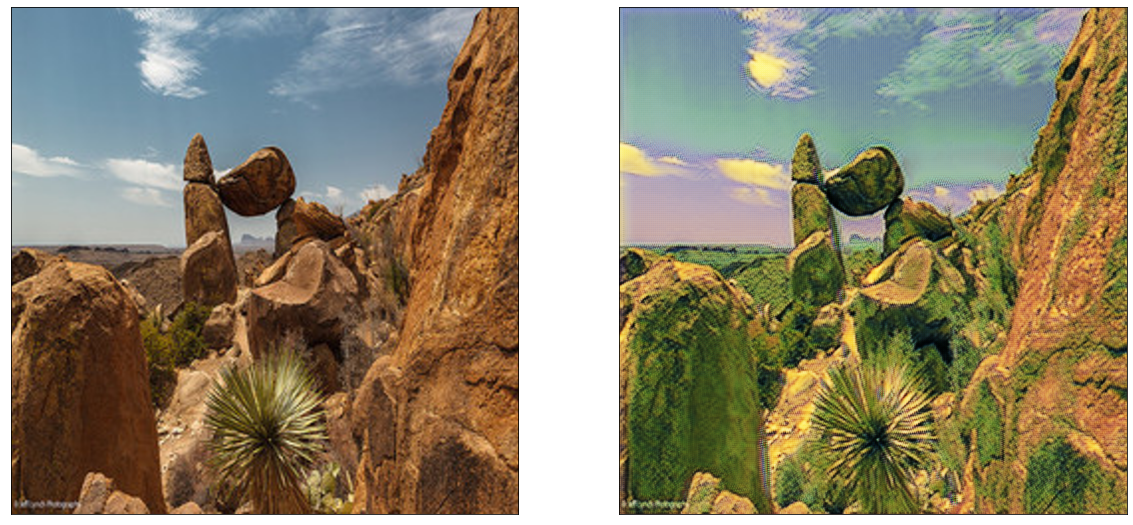

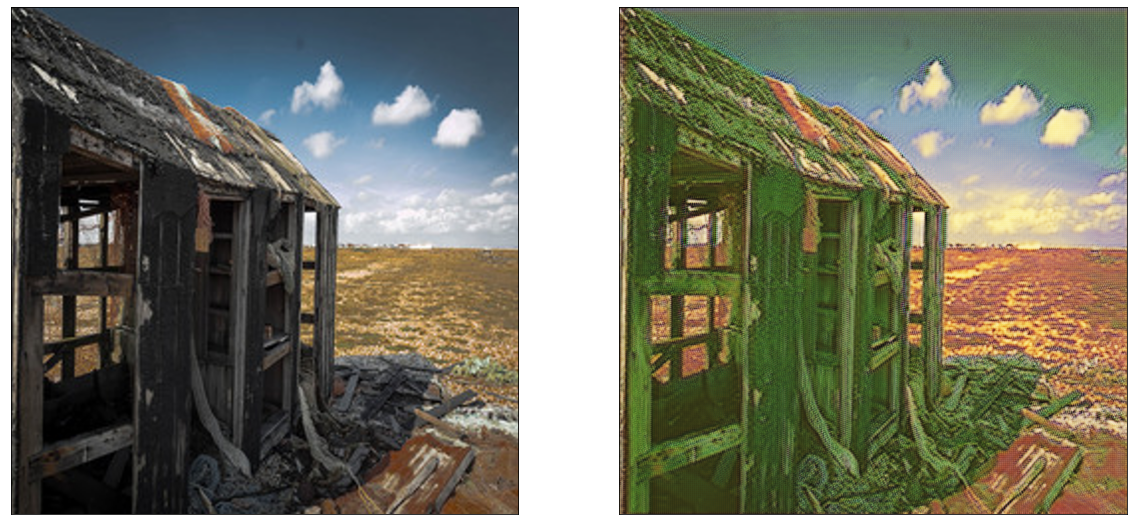

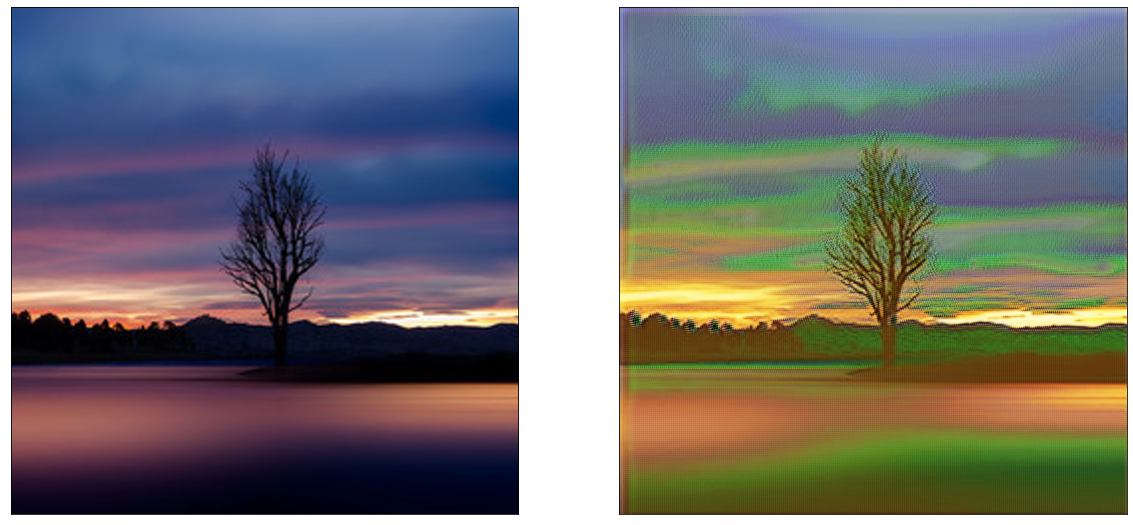

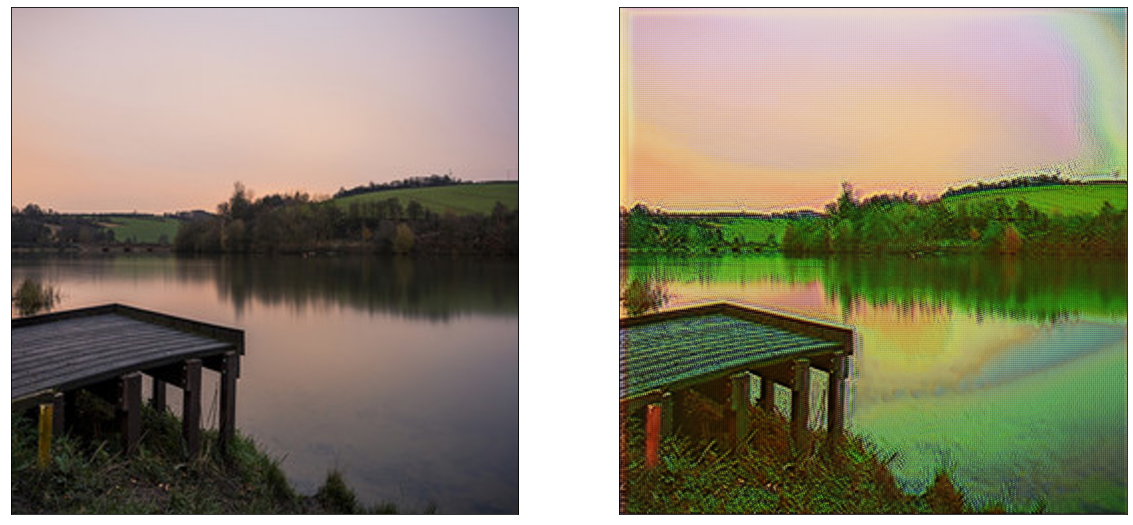

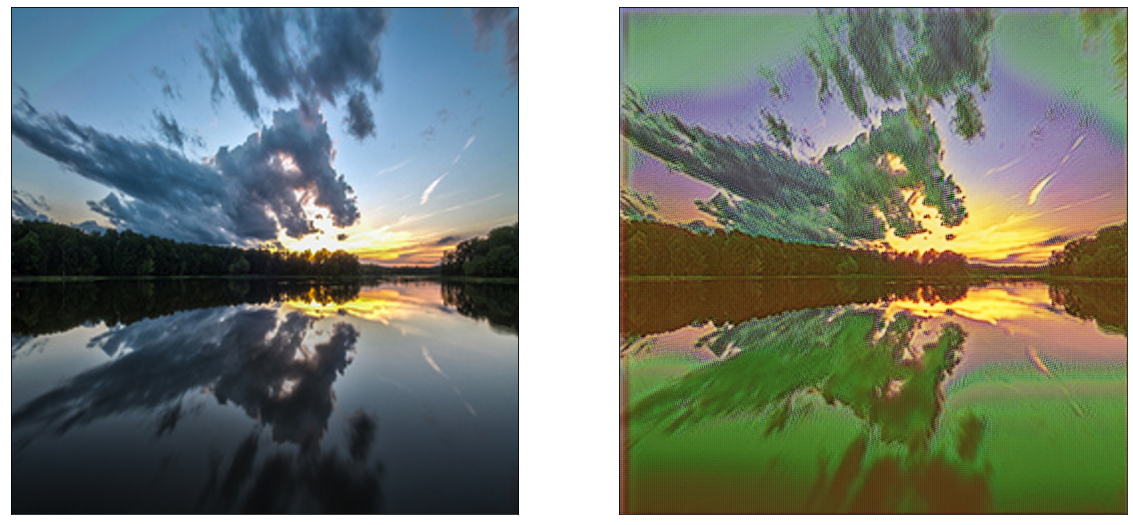

In [ ]:
# Observing the results


def unnormalize(img):
    return img * 0.5 + 0.5
    
# Helper to display images
def img_show(img):
    # Unnormalize first
    npimg = unnormalize(img).detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def show_img(img1, img2):
    figur = plt.figure(figsize=(20, 28))
    ax = figur.add_subplot(1, 2, 1, xticks=[], yticks=[])
    img_show(img1)
    ax = figur.add_subplot(1, 2, 2, xticks=[], yticks=[])
    img_show(img2)
    return figur

class InferDataset(torch.utils.data.Dataset):
    
    def __init__(self, photo_dir, img_size):
        self.photo_dir = photo_dir
        self.photo_imgs = []     
        for filename in os.listdir(photo_dir):
            self.photo_imgs.append(filename)

        self.transform = transforms.Compose([transforms.Resize(int(img_size), Image.BICUBIC),
                           transforms.ToTensor(),  
                           transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

        
    def __getitem__(self, index):
        return self.transform(Image.open(os.path.join(self.photo_dir, self.photo_imgs[(index) % len(self.photo_imgs)])).convert('RGB'))
    
    def __len__(self):
        return len(self.photo_dir)

# Inference Configs
img_size = 1024  # inference resolution is 1024
num = 5
model_dir = '/content/ph2pa_0200.pth'
img_dir = "/content/vangogh2photo/testB"
#"/content/vangogh2photo/testB"

dataset = InferDataset(img_dir, img_size)
model = Generator().cuda()
model.load(model_dir)

#evaluate the model
model.eval()   
with torch.no_grad(): #gradients are not computed during evaluation so they are off
    for i in tqdm.tqdm(range(num)):
        image = dataset.__getitem__(i).cuda().unsqueeze(0)
        generated_img = model(image).squeeze(0)
        result = show_img(image.squeeze(0), generated_img)

In [ ]:
!bash ./scripts/download_cyclegan_model.sh style_vangogh